## Install required dependencies

In [1]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-d9_20ka2
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-d9_20ka2
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.07709fc2909067eb0f213c262669e4c54299ff5d4_-cp37-none-any.whl size=150538 sha256=74ea0aa464b50b4807863d962d9e9db93c02cb15de43b76bbbb5f7b3932e7f6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-kfj8abf_/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


## Import required libraries

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tensorflow.keras import layers
import time
from tqdm import tqdm

from IPython import display
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
zip_file = 'gdrive/MyDrive/data.tgz'
os.path.exists(zip_file)

True

In [6]:
# un-comment to extract file
# !tar zxvf 'gdrive/MyDrive/data.tgz'

## Clean dataset

In [7]:
data_folder = 'cropped'
os.path.exists(data_folder)

True

In [8]:
errors = []
for img_name in os.listdir(data_folder):
  img_path = os.path.join(data_folder, img_name)
  try:
    img = Image.open(img_path)
  except:
    errors.append(img_path)
    os.remove(img_path)
print('Deleted files: {}'.format(len(errors)))

Deleted files: 63


## Load and prepare the dataset

In [9]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (64, 64))
  img = tf.image.convert_image_dtype(img, dtype=tf.float32)
  img = (img - 127.5) / 127.5
  return img

In [10]:
image_dataset = tf.data.Dataset.from_tensor_slices([os.path.join(data_folder, x) for x in os.listdir(data_folder)])
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
print(f'Length of dataset: {len(os.listdir(data_folder))}')

Length of dataset: 63569


In [12]:
BUFFER_SIZE = len(os.listdir(data_folder))
BATCH_SIZE = 256

In [13]:
# Batch and shuffle the data
train_dataset = image_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
next(iter(train_dataset)).shape

TensorShape([256, 64, 64, 3])

## Create the models

### The Generator

In [15]:
latent_dim = 100
height = 64
width = 64
channels = 3

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32 * 32 * 128, input_shape=(latent_dim,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((32, 32, 128)))

    model.add(layers.Conv2D(256, 5, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, 5, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(256, 5, padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(channels, 7, padding='same', activation='tanh'))
    return model

In [17]:
generator = make_generator_model()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 131072)            13238272  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 131072)            0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 256)       1048832   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 256)       0

In [19]:
noise = tf.random.normal([1, 100])

In [20]:
generated_image = generator(noise, training=False)

In [21]:
generated_image.shape

TensorShape([1, 64, 64, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


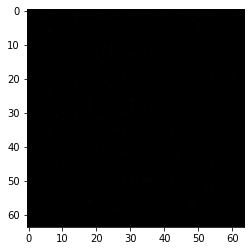

In [22]:
plt.imshow(generated_image[0, ...])

### The Discriminator

The discriminator is a CNN-based image classifier.

In [23]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, 3, input_shape=[height, width, channels]))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, 4, strides=2))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, 4, strides=2))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128, 4, strides=2))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [24]:
discriminator = make_discriminator_model()

In [25]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)        

In [26]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50004524]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

In [27]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

In [29]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [32]:
EPOCHS = 15
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [33]:
seed.shape

TensorShape([16, 100])

In [34]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [35]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [36]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, ...] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

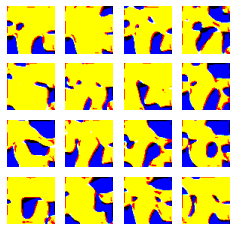

Time for epoch 11 is 1143.1338040828705 sec


In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

In [ ]:
plt.imshow(generated_image[0, ...] * 127.5 + 127.5)